In [1]:
import pandas as pd
from prophet import Prophet
import plotly.express as px

# Functions

In [2]:
from datetime import datetime


# function to remove last record if date is greater than sysdate

def datecheck(df):
    #Get todays date and convert to datetime format ymd
    today = datetime.today()
    
    #Get last date of dataframe
    last_dt = pd.to_datetime(df['ds'].tail(1))

    #test if last date is greater or equal to current datetime
    test_dt = last_dt <= today

    #if statement to remove last record from df given the last date is greater than current date
    if test_dt.bool() == True:
        return(df)
    else:
        df.drop(df.tail(1).index, inplace=True)
        return(df)


# URL request and data download csv

In [54]:
import pandas as pd
import time
from datetime import timedelta

#get the time now in unix time
now = int(time.time())

#get the time one year from now datetime object
day_lag = datetime.today() - timedelta(days = 30 )

#convert datetime object to unix timestamp
then = int(day_lag.timestamp())

#Build Yahoo Finance Url request for SOL one year worth of data from Now 
url = F'https://query1.finance.yahoo.com/v7/finance/download/SOL1-USD?period1={then}&period2={now}&interval=1d&events=history&includeAdjustedClose=true' #SOL
#url = F'https://query1.finance.yahoo.com/v7/finance/download/ETH-USD?period1={then}&period2={now}&interval=1d&events=history&includeAdjustedClose=true' #ETH
#url = F'https://query1.finance.yahoo.com/v7/finance/download/XRP-USD?period1={then}&period2={now}&interval=1d&events=history&includeAdjustedClose=true'  #XRP
#url = F'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1={then}&period2={now}&interval=1d&events=history&includeAdjustedClose=true' #BTC
#Get CSV file from Yahoo Finance
file = pd.read_csv(url)

#Convert download file to time series of date and close
file_ts = file[['Date','Close']]

#rename columns 'ds' = datestamp and Y = Y value for prophet
file_ts = file_ts.rename(columns={"Date": "ds", "Close": "y"})

#Drop Na values from file
df = file_ts.dropna(axis=0)

#use date check function to remove last row if date is greater than todays date
datecheck(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      29 non-null     object 
 1   y       29 non-null     float64
dtypes: float64(1), object(1)
memory usage: 696.0+ bytes


/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Use FB prophet to perform time series prediction

In [48]:
#Initiate prophet object
m = Prophet(changepoint_prior_scale=0.7)

#Fit the prophet object to the downloaded data
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


In [56]:
future = m.make_future_dataframe(periods=5)
future.tail()

SyntaxError: invalid syntax (2198056085.py, line 1)

In [50]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2021-10-12,144.760359,137.501353,152.579766
28,2021-10-13,149.141450,141.818824,156.506987
29,2021-10-14,148.901054,141.591282,156.929598
30,2021-10-15,149.787551,142.143409,157.857606
31,2021-10-16,154.078867,145.058510,163.468712


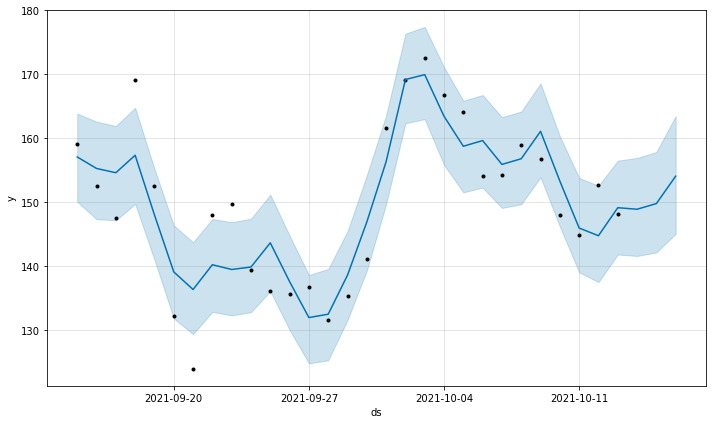

In [51]:
fig1 = m.plot(forecast)

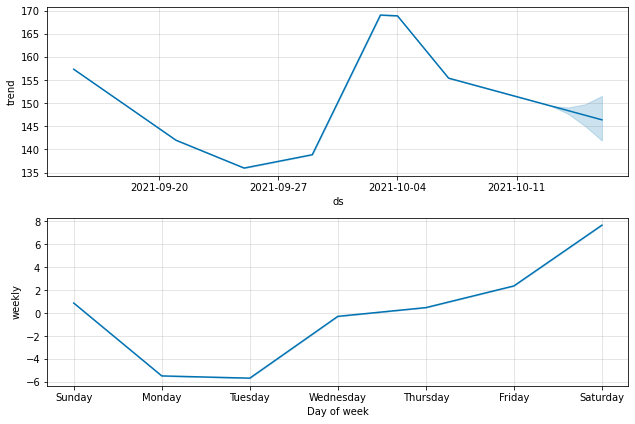

In [52]:
fig2 = m.plot_components(forecast)

In [53]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast,changepoints = True,trend = True)

# Cross Validation and Tunning

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools
import numpy as np

param_grid = {  
    'changepoint_prior_scale': [.7,0.75,0.8,.85,.90,.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Store the RMSEs for each params here
rmses = []  

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m,period='5 days', horizon='10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [44]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.95}


In [28]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mse',rolling_window = .1)

NameError: name 'df_cv' is not defined